# core

> Create messages for language models like Claude and OpenAI GPTs.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import base64
import mimetypes
from collections import abc

from fastcore import imghdr
from fastcore.meta import delegates
from fastcore.utils import *

## API Exploration
Anthropic's Claude and OpenAI's GPT models are some of the most popular LLMs. 

Let's take a look at their APIs and to learn how we should structure our messages for a simple text chat.

#### openai

In [ ]:
from openai import OpenAI

In [ ]:
client = OpenAI()

client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[ {"role": "user", "content": "Hello, world!"} ]
)

ChatCompletion(id='chatcmpl-AwxutFvFrBvjSeejfih4WDfcIRNo1', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1738616707, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_bd83329f63', usage=CompletionUsage(completion_tokens=10, prompt_tokens=11, total_tokens=21, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0, audio_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details={'cached_tokens': 0, 'audio_tokens': 0}))

#### anthropic

In [ ]:
from anthropic import Anthropic

In [ ]:
client = Anthropic()

client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1024,
    messages=[ {"role": "user", "content": "Hello, world!"} ]
)

Message(id='msg_01MJhQFAyz8RdH9C9jkm7tdi', content=[TextBlock(text="Hello! I'm an AI assistant created by Anthropic. How can I assist you today?", type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=11, output_tokens=23, cache_creation_input_tokens=0, cache_read_input_tokens=0))

As we can see both APIs use the exact same message structure.

### mk_msg

Ok, let's build the first version of `mk_msg` to handle this case

In [ ]:
def mk_msg(content:str, role:str="user")->dict:
    "Create an OpenAI/Anthropic compatible message."
    return dict(role=role, content=content)

Let's test it out with the OpenAI API. To do that we'll need to setup two things:

- install the openai SDK by running `pip install openai`
- add your openai api key to your env vars `export OPENAI_API_KEY="YOUR_OPEN_API_KEY"`

In [ ]:
oa_cli = OpenAI()

r = oa_cli.chat.completions.create(
  model="gpt-4o-mini",
  messages=[mk_msg("Hello, world!")]
)
r.choices[0].message.content

'Hello! How can I assist you today?'

Now, let's test out `mk_msg` on the Anthropic API. To do that we'll need to setup two things:

- install the openai SDK by running `pip install anthropic`
- add your anthropic api key to your env vars `export ANTHROPIC_API_KEY="YOUR_ANTHROPIC_API_KEY"`

In [ ]:
a_cli = Anthropic()

r = a_cli.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1024,
    messages=[mk_msg("Hello, world!")]
)
r.content[0].text

"Hello! It's a pleasure to meet you. I'm an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. Please let me know how I can be of assistance."

So far so good!

#### Helper Functions

Before going any further, let's create some helper functions to make it a little easier to call the OpenAI and Anthropic APIs. We're going to be making a bunch of API calls to test our code and typing the full expressions out each time will become a little tedious. These functions won't be included in the final package.

In [ ]:
def openai_chat(msgs: list)->tuple:
    "call the openai chat completions endpoint with `msgs`."
    r = oa_cli.chat.completions.create(model="gpt-4o-mini", messages=msgs)
    return r, r.choices[0].message.content

Let's double check that `mk_msg` still works with our simple text example from before.

In [ ]:
_, text = openai_chat([mk_msg("Hello, world!")])
text

'Hello! How can I assist you today?'

In [ ]:
def anthropic_chat(msgs: list)->tuple:
    "call the anthropic messages endpoint with `msgs`."
    r = a_cli.messages.create(model="claude-3-haiku-20240307", max_tokens=1024, messages=msgs)
    return r, r.content[0].text

and Anthropic...

In [ ]:
_, text = anthropic_chat([mk_msg("Hello, world!")])
text

"Hello! I'm an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. How can I assist you today?"

### Images

Ok, let's see how both APIs handle image messages.

<img src="https://www.atshq.org/wp-content/uploads/2022/07/shutterstock_1626122512.jpg" height=240 width=240></img>

#### openai

In [ ]:
import base64, httpx

In [ ]:
img_url = "https://claudette.answer.ai/index_files/figure-html/cell-35-output-1.jpeg"

In [ ]:
mtype = "image/jpeg"
img = base64.b64encode(httpx.get(img_url).content).decode("utf-8")

client = OpenAI()
client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role":"user",
            "content": [
                {"type":"text","text":"What's in this image?"},
                {"type":"image_url","image_url":{"url":f"data:{mtype};base64,{img}"}},
            ],
        }
    ],
)

ChatCompletion(id='chatcmpl-Awxv1j0M9xACPlg1X5VnUF5w25i8F', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image features a cute puppy with brown and white fur lying on green grass. The puppy is resting near a patch of purple flowers, adding to the colorful and serene outdoor setting.', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1738616715, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_bd83329f63', usage=CompletionUsage(completion_tokens=37, prompt_tokens=452, total_tokens=489, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0, audio_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details={'cached_tokens': 0, 'audio_tokens': 0}))

#### anthropic

In [ ]:
mtype = "image/jpeg"
img = base64.b64encode(httpx.get(img_url).content).decode("utf-8")

client = Anthropic()
client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1024,
    messages=[
        {
            "role":"user",
            "content": [
                {"type":"text","text":"What's in this image?"},
                {"type":"image","source":{"type":"base64","media_type":mtype,"data":img}}
            ],
        }
    ],
)

Message(id='msg_01YZrV1h5fkdT27pXaiff99W', content=[TextBlock(text="This image shows a cute puppy lying in a grassy area with some purple flowers in the background. The puppy appears to be a Cavalier King Charles Spaniel, with its soft-looking fur and large, expressive eyes. The puppy looks relaxed and content, gazing out at the viewer. The vibrant purple flowers provide a lovely natural setting for the puppy's portrait.", type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=104, output_tokens=86, cache_creation_input_tokens=0, cache_read_input_tokens=0))

Both APIs format images slightly differently and the structure of the message `content` is a litte more complex. 

In a text chat, `content` is a simple string but for a multimodal chat (text+images) we can see that `content` is a list of dictionaries.

### Msg Class

To handle the additional complexity of multimodal messages let's build a `Msg` class for the `content` data structure:

```json
{
    "role": "user",
    "content": [{"type": "text", "text": "What's in this image?"}],
}
```

In [ ]:
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:[list,str], **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        if content is not None and not isinstance(content, list): content = [content]
        return dict(role=role, content=[{"type":"text", "content":item} for item in content], **kw)

Now, let's update `mk_msg` to use `Msg`.

In [ ]:
def mk_msg(content:str, role:str="user", **kw)->dict:
    "Create an OpenAI/Anthropic compatible message."
    return Msg()(role, content, **kw)

In [ ]:
mk_msg(["Hello world", "how are you?"])

{'role': 'user',
 'content': [{'type': 'text', 'content': 'Hello world'},
  {'type': 'text', 'content': 'how are you?'}]}

Now, let's update `Msg` so that it can format our images correctly.

First, we'll add a method `mk_content` where we can check the type of each input and format the data appropriately. Let's start by adding a check for text data.

In [ ]:
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:[list,str], **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        if content is not None and not isinstance(content, list): content = [content]
        content = [self.mk_content(o) for o in content] if content else ''
        return dict(role=role, content=content, **kw)
    
    def text_msg(self, s:str)->dict: 
        "Convert `s` to a text message"
        return {"type": "text", "text":s}
    
    def mk_content(self, content:str)->dict:
        "Create the appropriate data structure based the content type."
        if isinstance(content, str): return self.text_msg(content)
        return content

Here's where things get a little tricker. As both APIs handle images differently let's subclass `Msg` for each API and handle the image formatting in a method called `img_msg`.

In [ ]:
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:[list,str], **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        if content is not None and not isinstance(content, list): content = [content]
        content = [self.mk_content(o) for o in content] if content else ''
        return dict(role=role, content=content, **kw)
    
    def img_msg(self, *args)->dict: 
        "Convert bytes to an image message"
        raise NotImplemented
        
    def text_msg(self, s:str)->dict: 
        "Convert `s` to a text message"
        return {"type": "text", "text":s}
    
    def mk_content(self, content:str)->dict:
        "Create the appropriate data structure based the content type."
        if isinstance(content, str): return self.text_msg(content)
        if isinstance(content, bytes): return self.img_msg(content)
        return content

In [ ]:
class OpenAiMsg(Msg):
    "Helper class to create a message for the OpenAI API."
    def img_msg(self, data:bytes)->dict:
        "Convert `data` to an image message"
        img = base64.b64encode(data).decode("utf-8")
        mtype = mimetypes.types_map["." + imghdr.what(None, h=data)]
        r = {"url": f"data:{mtype};base64,{img}"}
        return {"type": "image_url", "image_url": r}

In [ ]:
class AnthropicMsg(Msg):
    "Helper class to create a message for the Anthropic API."
    def img_msg(self, data:bytes)->dict:
        "Convert `data` to an image message"
        img = base64.b64encode(data).decode("utf-8")
        mtype = mimetypes.types_map["." + imghdr.what(None, h=data)]
        r = {"type": "base64", "media_type": mtype, "data":img}
        return {"type": "image", "source": r}

Now, let's update `mk_msg` so that it chooses the appropriate `Msg` subclass.

In [ ]:
def mk_msg(content:str, role:str="user", *args, api:str="openai", **kw) -> dict:
    "Create an OpenAI/Anthropic compatible message."
    m = OpenAiMsg() if api == "openai" else AnthropicMsg()
    return m(role, content, **kw)

Ok, let's test our changes...

In [ ]:
from IPython.display import Image, display

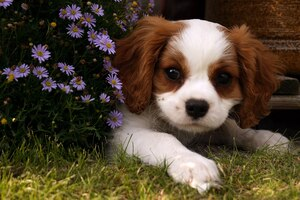

In [ ]:
img = httpx.get(img_url).content
display(Image(img))

In [ ]:
msg = mk_msg([img, "describe this picture"], api="openai")
_, text = openai_chat([msg])
text

'The image features a cute puppy laying in a grassy area, partially hidden by a cluster of purple flowers. The puppy has a mostly white coat with brown markings on its ears and around its eyes. Its large, expressive eyes give it an adorable appearance, and the overall setting looks peaceful and vibrant with the flowers surrounding the pup.'

In [ ]:
msg = mk_msg([img, "describe this picture"], api="anthropic")
_, text = anthropic_chat([msg])
text

'The image shows a young, fluffy puppy lying on a grassy lawn. The puppy has a white and brown coat, with large, expressive eyes and floppy ears. The puppy appears to be looking directly at the camera with a curious and friendly expression. In the background, there are several vibrant purple flowers, adding a lovely, natural setting to the scene. Overall, the image captures the adorable and endearing nature of this puppy, inviting the viewer to appreciate the charming beauty of this young canine companion.'

Great! Before moving on let's create `_mk_img` to make our code a little DRY'r. 

In [ ]:
#|exports
def _mk_img(data:bytes)->tuple:
    "Convert image bytes to a base64 encoded image"
    img = base64.b64encode(data).decode("utf-8")
    mtype = mimetypes.types_map["."+imghdr.what(None, h=data)]
    return img, mtype

Let's use `_mk_img` in our `Msg` subclasses

In [ ]:
class OpenAiMsg(Msg):
    "Helper class to create a message for the OpenAI API."
    def img_msg(self, data:bytes)->dict:
        "Convert `data` to an image message"
        img, mtype = _mk_img(data)
        r = {"url": f"data:{mtype};base64,{img}"}
        return {"type": "image_url", "image_url": r}

In [ ]:
class AnthropicMsg(Msg):
    "Helper class to create a message for the Anthropic API."
    def img_msg(self, data:bytes)->dict:
        "Convert `data` to an image message"
        img, mtype = _mk_img(data)
        r = {"type": "base64", "media_type": mtype, "data":img}
        return {"type": "image", "source": r}

### PDFs

What about chatting with PDFs? Unfortunately, OpenAI's message completions API doesn't offer PDF support at the moment, but Claude [does](https://docs.anthropic.com/en/docs/build-with-claude/pdf-support). 

Under the hood, Claude extracts the text from the PDF and converts each page to an image. This means you can ask Claude about any text, pictures, charts, and tables in the PDF. Here's an example from the Claude [docs](https://docs.anthropic.com/en/docs/build-with-claude/pdf-support#how-to-use-pdfs-in-the-messages-api). Overall the message structure is pretty similar to an image message.

```python
import anthropic
import base64
import httpx

# First fetch the file
pdf_url = "https://assets.anthropic.com/m/1cd9d098ac3e6467/original/Claude-3-Model-Card-October-Addendum.pdf"
pdf_data = base64.standard_b64encode(httpx.get(pdf_url).content).decode("utf-8")

beta_client = anthropic.Anthropic(default_headers={'anthropic-beta': 'pdfs-2024-09-25, prompt-caching-2024-07-31'})
message = beta_client.messages.create(
    model="claude-3-5-sonnet-20241022",
    betas=["pdfs-2024-09-25"],
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "document",
                    "source": {
                        "type": "base64",
                        "media_type": "application/pdf",
                        "data": pdf_data
                    }
                },
                {
                    "type": "text",
                    "text": "Which model has the highest human preference win rates across each use-case?"
                }
            ]
        }
    ],
)
```

As Claude PDF support is currently in beta, we need to update our default headers to include `pdfs-2024-09-25`. 

In [ ]:
a_cli = Anthropic(default_headers={'anthropic-beta': 'pdfs-2024-09-25'})

PDF support is only available on Sonnet so we also need to update `anthropic_chat` to use `sonnet`

In [ ]:
def anthropic_chat(msgs: list)->tuple:
    "call the anthropic messages endpoint with `msgs`."
    r = a_cli.messages.create(model="claude-3-5-sonnet-20241022", max_tokens=1024, messages=msgs)
    return r, r.content[0].text

We'll need to update `Msg.mk_content` so that it can detect if a byte string is an image or pdf. 

Let's write some helper functions for `Msg.mk_content` to use.

In [ ]:
#|exports
def _is_img(data): return isinstance(data, bytes) and bool(imghdr.what(None, data))

A PDF [file](https://docs.fileformat.com/pdf/#pdf-file-header) should start with `%PDF` followed by the pdf version `%PDF-1.1`

In [ ]:
#|exports
def _is_pdf(data): return isinstance(data, bytes) and data.startswith(b'%PDF-')

Now, let's update `mk_content` to use these methods. Let's also add a `pdf_msg` method as well.

In [ ]:
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:[list,str], **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        if content is not None and not isinstance(content, list): content = [content]
        content = [self.mk_content(o) for o in content] if content else ''
        return dict(role=role, content=content, **kw)
    
    def img_msg(self, *args)->dict: 
        "Convert bytes to an image message"
        raise NotImplemented
        
    def text_msg(self, s:str)->dict: 
        "Convert `s` to a text message"
        return {"type": "text", "text":s}
    
    def pdf_msg(self, *args, **kw)->dict:
        "Convert bytes to a pdf message"
        raise NotImplemented
        
    def mk_content(self, content:[str, bytes]):
        "Create the appropriate data structure based the content type."
        if isinstance(content, str): return self.text_msg(content)
        if _is_img(content): return self.img_msg(content)
        if _is_pdf(content): return self.pdf_msg(content)
        return content

Next, let's create a method that converts a byte string to the base64 encoded string that Anthropic expects.

In [ ]:
#|exports
def _mk_pdf(data:bytes)->str:
    "Convert pdf bytes to a base64 encoded pdf"
    return base64.standard_b64encode(data).decode("utf-8")

Finally, let's add a `pdf_msg` method to `AnthropicMsg` that uses `_mk_pdf`.

In [ ]:
class AnthropicMsg(Msg):
    "Helper class to create a message for the Anthropic API."
    def img_msg(self, data:bytes)->dict:
        "Convert `data` to an image message"
        img, mtype = _mk_img(data)
        r = {"type": "base64", "media_type": mtype, "data":img}
        return {"type": "image", "source": r}
    
    def pdf_msg(self, data: bytes) -> dict:
        "Convert `data` to a pdf message"
        r = {"type": "base64", "media_type": "application/pdf", "data":_mk_pdf(data)}
        return {"type": "document", "source": r}

Let's test our changes on a financial report.

In [ ]:
from pathlib import Path

In [ ]:
pdf = Path('financial_report.pdf').read_bytes()
msg = mk_msg([pdf, "what was the average monthly revenue for product D?"], api="anthropic")
_, text = anthropic_chat([msg])
text

'Let me calculate the average monthly revenue for Product D by summing up all monthly values and dividing by 12.\n\nMonthly revenues for Product D:\nJan: ~900\nFeb: ~500\nMar: ~400\nApr: ~700\nMay: ~800\nJun: ~900\nJul: ~1000\nAug: ~1050\nSep: ~1200\nOct: ~1300\nNov: ~1300\nDec: ~1300\n\nTotal = 11,350 (approximately)\nAverage = 11,350 ÷ 12 = 945.83\n\nThe average monthly revenue for Product D in fiscal year 2023 was approximately $946.'

### Text Only Models

Ok, what next? Some text only models that follow the OpenAI API spec such as Qwen, expect messages to have the following format

```json
{"role": "user", "content": "Hello, world!"}
```

Let's update our code to support this use-case.

In [ ]:
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    def __call__(self, role:str, content:[list, str], text_only:bool=False, **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        if content is not None and not isinstance(content, list): content = [content]
        content = [self.mk_content(o, text_only=text_only) for o in content] if content else ''
        return dict(role=role, content=content[0] if text_only else content, **kw)
    
    def img_msg(self, *args, **kw)->dict: 
        "Convert bytes to an image message"
        raise NotImplemented
        
    def text_msg(self, s:str, text_only=False, **kw): 
        "Convert `s` to a text message"
        return s if text_only else {"type":"text", "text":s}
    
    def pdf_msg(self, *args, **kw)->dict:
        "Convert bytes to a pdf message"
        raise NotImplemented
                
    def mk_content(self, content, text_only=False)->dict:
        if isinstance(content, str): return self.text_msg(content, text_only=text_only)
        if _is_img(content): return self.img_msg(content)
        if _is_pdf(content): return self.pdf_msg(content)
        return content

In [ ]:
class OpenAiMsg(Msg):
    "Helper class to create a message for the OpenAI API."
    def img_msg(self, data)->dict:
        "Convert `data` to an image message"
        img, mtype = _mk_img(data)
        r = {"url": f"data:{mtype};base64,{img}"}
        return {"type": "image_url", "image_url": r}

In [ ]:
class AnthropicMsg(Msg):
    "Helper class to create a message for the Anthropic API."
    def img_msg(self, data)->dict:
        "Convert `data` to an image message"
        img, mtype = _mk_img(data)
        r = dict(type='base64', media_type=mtype, data=img)
        return {"type": "image", "source": r}

    def pdf_msg(self, data: bytes) -> dict:
        "Convert `data` to a pdf message"
        r = {"type": "base64", "media_type": "application/pdf", "data":_mk_pdf(data)}
        return {"type": "document", "source": r}

In [ ]:
def mk_msg(content:Union[list,str], role:str="user", *args, api:str="openai", text_only=False, **kw)->dict:
    "Create an OpenAI/Anthropic compatible message."
    m = OpenAiMsg if api == "openai" else AnthropicMsg
    return m()(role, content, text_only=text_only, **kw)

In [ ]:
mk_msg("describe this picture", text_only=True)

{'role': 'user', 'content': 'describe this picture'}

In [ ]:
mk_msg("describe this picture")

{'role': 'user',
 'content': [{'type': 'text', 'text': 'describe this picture'}]}

Manually setting the message format is a little annoying. Instead, let's automatically apply the simpler format if `content` is a string or a list comprised of a single string. 

*Note*: We don't apply the simpler format when `content` is a list comprised of multiple strings, because this would require us to join the strings into a single string.

In [ ]:
def mk_msg(content:Union[list,str], role:str="user", *args, api:str="openai", **kw)->dict:
    "Create an OpenAI/Anthropic compatible message."
    text_only = isinstance(content, str) or (isinstance(content, list) and len(content) == 1 and isinstance(content[0], str))
    m = OpenAiMsg if api == "openai" else AnthropicMsg
    return m()(role, content, text_only=text_only, **kw)

In [ ]:
mk_msg("describe this picture")

{'role': 'user', 'content': 'describe this picture'}

If `content` is a list comprised of a single string, we still use the simpler format.

In [ ]:
mk_msg(["describe this picture"])

{'role': 'user', 'content': 'describe this picture'}

If `content` is a list with multiple items, we use the more detailed format.

In [ ]:
mk_msg(["describe this picture", "and tell me a joke"])

{'role': 'user',
 'content': [{'type': 'text', 'text': 'describe this picture'},
  {'type': 'text', 'text': 'and tell me a joke'}]}

To make life a little easier, let's use fastcore's [dict2obj](https://fastcore.fast.ai/xtras.html#dict2obj) to convert the output of `mk_msg` to an `AttrDict`. This will allow us to use `msg.content` and `msg.role` instead of having to do lookups like `msg['content']` and `msg['role']`. 

In [ ]:
#| export
def mk_msg(content:Union[list,str], role:str="user", *args, api:str="openai", **kw)->dict:
    "Create an OpenAI/Anthropic compatible message."
    text_only = isinstance(content, str) or (isinstance(content, list) and len(content) == 1 and isinstance(content[0], str))
    m = OpenAiMsg if api == "openai" else AnthropicMsg
    msg = m()(role, content, text_only=text_only, **kw)
    return dict2obj(msg, list_func=list)

In [ ]:
msg = mk_msg(["describe this picture"])

In [ ]:
msg["role"], msg["content"]

('user', 'describe this picture')

In [ ]:
msg.role, msg.content

('user', 'describe this picture')

### Conversation

LLMs are stateless. To continue a conversation we need to include the entire message history in every API call.
By default the role in each message alternates between `user` and `assistant`.

Let's add a method that alternates the roles for us and then calls `mk_msgs`.

In [ ]:
#| export
def mk_msgs(msgs: list, *args, api:str="openai", **kw) -> list:
    "Create a list of messages compatible with OpenAI/Anthropic."
    if isinstance(msgs, str): msgs = [msgs]
    return [mk_msg(o, ('user', 'assistant')[i % 2], *args, api=api, **kw) for i, o in enumerate(msgs)]

In [ ]:
mk_msgs(["Hello", "Some assistant response", "tell me a joke"])

[{'role': 'user', 'content': 'Hello'},
 {'role': 'assistant', 'content': 'Some assistant response'},
 {'role': 'user', 'content': 'tell me a joke'}]

### SDK Objects

To make our lives even easier, it would be nice if `mk_msg` could format the SDK objects returned from a previous chat so that we can pass them straight to `mk_msgs`.

The OpenAI SDK accepts objects like `ChatCompletion` as messages. Anthropic is different and expects every message to have the `role`, `content` format that we've seen so far.

In [ ]:
#| export
class Msg:
    "Helper class to create a message for the OpenAI and Anthropic APIs."
    sdk_obj_support=False # is an SDK object a valid message?
    def __call__(self, role:str, content:[list,str], text_only:bool=False, **kw)->dict:
        "Create an OpenAI/Anthropic compatible message with `role` and `content`."
        if self.sdk_obj_support and self.is_sdk_obj(content): return self.find_block(content)
        if hasattr(content, "content"): content, role = content.content, content.role
        content = self.find_block(content)
        if content is not None and not isinstance(content, list): content = [content]
        content = [self.mk_content(o, text_only=text_only) for o in content] if content else ''
        return dict(role=role, content=content[0] if text_only else content, **kw)

    def is_sdk_obj(self, r)-> bool:
        "Check if `r` is an SDK object."
        raise NotImplemented
        
    def find_block(self, r)->dict:
        "Find the message in `r`."
        raise NotImplemented

    def text_msg(self, s:str, text_only:bool=False, **kw):
        "Convert `s` to a text message"
        return s if text_only else {"type":"text", "text":s}

    def img_msg(self, *args, **kw)->dict:
        "Convert bytes to an image message"
        raise NotImplemented

    def pdf_msg(self, *args, **kw)->dict:
        "Convert bytes to a pdf message"
        raise NotImplemented
    
    def mk_content(self, content:[str, bytes], text_only:bool=False) -> dict:
        "Create the appropriate data structure based the content type."
        if isinstance(content, str): return self.text_msg(content, text_only=text_only)
        if _is_img(content): return self.img_msg(content)
        if _is_pdf(content): return self.pdf_msg(content)
        return content

In [ ]:
#| export
class AnthropicMsg(Msg):
    sdk_obj_support=False
    def img_msg(self, data: bytes) -> dict:
        "Convert `data` to an image message"
        img, mtype = _mk_img(data)
        r = {"type": "base64", "media_type": mtype, "data":img}
        return {"type": "image", "source": r}

    def pdf_msg(self, data: bytes) -> dict:
        "Convert `data` to a pdf message"
        r = {"type": "base64", "media_type": "application/pdf", "data":_mk_pdf(data)}
        return {"type": "document", "source": r}
    
    def is_sdk_obj(self, r)-> bool:
        "Check if `r` is an SDK object."
        return isinstance(r, abc.Mapping)

    def find_block(self, r):
        "Find the message in `r`."
        return r.get('content', r) if self.is_sdk_obj(r) else r

In [ ]:
#| export
class OpenAiMsg(Msg):
    sdk_obj_support=True
    def img_msg(self, data: bytes) -> dict:
        "Convert `data` to an image message"
        img, mtype = _mk_img(data)
        r = {"url": f"data:{mtype};base64,{img}"}
        return {"type": "image_url", "image_url": r}

    def is_sdk_obj(self, r)-> bool:
        "Check if `r` is an SDK object."
        return type(r).__module__ != "builtins"

    def find_block(self, r):
        "Find the message in `r`."
        if not self.is_sdk_obj(r): return r
        m = nested_idx(r, "choices", 0)
        if not m: return m
        if hasattr(m, "message"): return m.message
        return m.delta

Let's test our changes.

In [ ]:
msgs = ["tell me a joke"]
r, text = openai_chat(mk_msgs(msgs))
text

"Why don't skeletons fight each other?\n\nThey don't have the guts!"

In [ ]:
msgs += [r, "tell me another joke that's similar to your first joke"]
r, text = openai_chat(mk_msgs(msgs))
text

'Why did the scarecrow win an award?\n\nBecause he was outstanding in his field!'

### Usage

To make `msglm` a little easier to use let's create OpenAI and Anthropic wrappers for `mk_msg` and `mk_msgs`.

In [ ]:
#| export
mk_msg_openai = partial(mk_msg, api="openai")
mk_msgs_openai = partial(mk_msgs, api="openai")

In [ ]:
mk_msg_anthropic = partial(mk_msg, api="anthropic")
mk_msgs_anthropic = partial(mk_msgs, api="anthropic")

If you're using OpenAI you should be able to use the import below

```python
from msglm import mk_msg_openai as mk_msg, mk_msgs_openai as mk_msgs
```

Similarily for Anthropic

```python
from msglm import mk_msg_anthropic as mk_msg, mk_msgs_anthropic as mk_msgs
```

### Caching

Anthropic currently offers [prompt caching](https://docs.anthropic.com/en/docs/build-with-claude/prompt-caching), which can reduce cost and latency.

To cache a message, we simply add a `cache_control` field to our content as shown below.

```js
{
    "role": "user",
    "content": [
        {
            "type": "text",
            "text": "Hello, can you tell me more about the solar system?",
            "cache_control": {"type": "ephemeral"}
        }
    ]
}
```

Let's update our `mk_msg` and `mk_msgs` Anthropic wrappers to support caching.

In [ ]:
#| export
def _add_cache_control(msg, cache=False):
    "cache `msg`."
    if not cache: return msg
    if isinstance(msg["content"], str): msg["content"] = [{"type": "text", "text": msg["content"]}]
    if isinstance(msg["content"][-1], dict): msg["content"][-1]["cache_control"] = {"type": "ephemeral"}
    elif isinstance(msg["content"][-1], abc.Mapping): msg["content"][-1].cache_control = {"type": "ephemeral"}
    return msg

def _remove_cache_ckpts(msg):
    "remove unecessary cache checkpoints."
    if isinstance(msg["content"], str): msg["content"] = [{"type": "text", "text": msg["content"]}]
    elif isinstance(msg["content"][-1], dict): msg["content"][-1].pop('cache_control', None)
    else: delattr(msg["content"][-1], 'cache_control') if hasattr(msg["content"][-1], 'cache_control') else None
    return msg


@delegates(mk_msg)
def mk_msg_anthropic(*args, cache=False, **kwargs):
    "Create an Anthropic compatible message."
    msg = partial(mk_msg, api="anthropic")(*args, **kwargs)
    return _add_cache_control(msg, cache=cache)

@delegates(mk_msgs)
def mk_msgs_anthropic(*args, cache=False, cache_last_ckpt_only=False, **kwargs):
    "Create a list of Anthropic compatible messages."
    msgs = partial(mk_msgs, api="anthropic")(*args, **kwargs)
    if cache_last_ckpt_only: msgs = [_remove_cache_ckpts(m) for m in msgs]
    if not msgs: return msgs
    msgs[-1] = _add_cache_control(msgs[-1], cache=cache)
    return msgs

Let's see caching in action

In [ ]:
mk_msg_anthropic("Don't cache my message")

```json
{'content': "Don't cache my message", 'role': 'user'}
```

In [ ]:
mk_msg_anthropic("Please cache my message", cache=True)

```json
{ 'content': [ { 'cache_control': {'type': 'ephemeral'},
                 'text': 'Please cache my message',
                 'type': 'text'}],
  'role': 'user'}
```

### Citations

The Anthropic API provides detailed [citations](https://docs.anthropic.com/en/docs/build-with-claude/citations) when answering questions about documents.

When citations are enabled a citations block like the one below will be included in the response.

```js
{
  "content": [
    {
      "type": "text",
      "text": "According to the document, "
    },
    {
      "type": "text",
      "text": "the grass is green",
      "citations": [{
        "type": "char_location",
        "cited_text": "The grass is green.",
        "document_index": 0,
        "document_title": "Example Document",
        "start_char_index": 0,
        "end_char_index": 20
      }]
    }
  ]
}
```

To enable citations you need to create an Anthropic document with the following structure.

```js
{
    "type": "document",
    "source": {...},
    "title": "Document Title", # optional
    "context": "Context about the document that will not be cited from", # optional
    "citations": {"enabled": True}
}
```

Currently Anthropic supports citations on 3 document types:
- text
- pdfs
- custom

A **text** document has the following source structure.

```js
{"type": "text", "media_type": "text/plain", "data": "Plain text content..."}
```

Here's the source structure for a **pdf**.

```js
{"type": "base64", "media_type": "application/pdf", "data": b64_enc_data}
```

Finally, here's the source structure for a **custom** document.

```js
{
  "type": "content",
  "content": [
    {"type": "text", "text": "First chunk"},
    {"type": "text", "text": "Second chunk"}
  ]
}
```

In [ ]:
#| export
def mk_ant_doc(content, title=None, context=None, citation=True, **kws):
    "Create an Anthropic document."
    if _is_pdf(content): src = {"type":"base64", "media_type":"application/pdf", "data":_mk_pdf(content)}
    elif isinstance(content,list): src = {"type":"content", "content":content}
    else: src = {"type":"text", "media_type":"text/plain", "data":content}
    return {"type":"document", "source":src, "citations":{"enabled":citation}, "title":title, "context":context, **kws}

Here's how you would implement the example from the citation's [docs](https://docs.anthropic.com/en/docs/build-with-claude/citations).

In [ ]:
doc = mk_ant_doc("The grass is green. The sky is blue.", title="My Document", context="This is a trustworthy document.")
mk_msg([doc, "What color is the grass and sky?"])

```json
{ 'content': [{'type': 'document', 'source': {'type': 'text', 'media_type': 'text/plain', 'data': 'The grass is green. The sky is blue.'}, 'citations': {'enabled': True}, 'title': 'My Document', 'context': 'This is a trustworthy document.'}, {'type': 'text', 'text': 'What color is the grass and sky?'}],
  'role': 'user'}
```

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()